# Overview

This notebook classifies spectrograms using multiple convolutional neural network (CNN) backbones.

# Preparation

## Google Colab

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# specify path in Google Drive
dir = '/content/drive/MyDrive/ECS_171_Group_9/'

# add path in Google Drive to system path
# reference: https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab
import sys
sys.path.append(dir)

Mounted at /content/drive


## Libraries

In [ ]:
import os
from PIL import Image

import numpy  as np
import pandas as pd

from random import shuffle, sample
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import seaborn as sn

# save models
from google.colab import files

from sklearn.metrics import confusion_matrix

Set random seed

In [ ]:
seed = 171
torch.manual_seed(seed)

# Dataset

## Load spectrograms

In [ ]:
train_de_pth = [dir + 'dataset/train/de/' + name for name in os.listdir(dir + 'dataset/train/de')]
train_en_pth = [dir + 'dataset/train/en/' + name for name in os.listdir(dir + 'dataset/train/en')]
test_de_pth  = [dir + 'dataset/test/de/'  + name for name in os.listdir(dir + 'dataset/test/de' )]
test_en_pth  = [dir + 'dataset/test/en/'  + name for name in os.listdir(dir + 'dataset/test/en' )]

train_pth = train_de_pth + train_en_pth
shuffle(train_pth)
test_pth  = test_de_pth  + test_en_pth

print(f'There are {len(train_pth)} spectrograms in the training set.')
print('German:', len(train_de_pth), 'spectrograms')
print('English:', len(train_en_pth), 'spectrograms')

print(f'\nThere are {len(test_pth)} spectrograms in the test set.')
print('German:', len(test_de_pth), 'spectrograms')
print('English:', len(test_en_pth), 'spectrograms')

There are 12178 spectrograms in the training set.
German: 6090 spectrograms
English: 6088 spectrograms

There are 180 spectrograms in the test set.
German: 90 spectrograms
English: 90 spectrograms


In [ ]:
train_de_df = pd.DataFrame({'file' : [name for name in os.listdir(dir + 'dataset/train/de')],
                            'label': [0,] * len(train_de_pth)})
train_en_df = pd.DataFrame({'file' : [name for name in os.listdir(dir + 'dataset/train/en')],
                            'label': [1,] * len(train_en_pth)})

test_de_df = pd.DataFrame({'file' : [name for name in os.listdir(dir + 'dataset/test/de')],
                           'label': [0,] * len(test_de_pth)})
test_en_df = pd.DataFrame({'file' : [name for name in os.listdir(dir + 'dataset/test/en')],
                           'label': [1,] * len(test_en_pth)})

train_df = pd.concat([train_de_df,
                      train_en_df])
test_df  = pd.concat([test_de_df,
                      test_en_df])
print(train_df)

                                                   file  label
0     m_502293f229751563d1768dd2367a6b29.fragment17....      0
1     m_502293f229751563d1768dd2367a6b29.fragment5.s...      0
2     m_502293f229751563d1768dd2367a6b29.fragment8.s...      0
3     m_502293f229751563d1768dd2367a6b29.fragment5.n...      0
4     m_502293f229751563d1768dd2367a6b29.fragment23....      0
...                                                 ...    ...
6083  m_011f3a2d0aa2880305c08b76873c3e10.fragment11....      1
6084  m_011f3a2d0aa2880305c08b76873c3e10.fragment13....      1
6085  m_011f3a2d0aa2880305c08b76873c3e10.fragment10....      1
6086  m_011f3a2d0aa2880305c08b76873c3e10.fragment12....      1
6087  m_011f3a2d0aa2880305c08b76873c3e10.fragment12....      1

[12178 rows x 2 columns]


## Construct `Dataset` and `DataLoader`

In [ ]:
from dataset import SpectrogramDataset

In [ ]:
batch_size = 8

In [ ]:
# training set
train_ds = SpectrogramDataset(train_pth, train_df)
train_loader = DataLoader(train_ds,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
print('training set size:', len(train_ds))

# test set
test_ds = SpectrogramDataset(test_pth, test_df)
test_loader = DataLoader(test_ds,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=2)
print('test set size:', len(test_ds))

training set size: 12178
test set size: 180


# Experiments

Use a GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


In [ ]:
from training import train_1_epoch, evaluate_1_epoch

## GoogLeNet

Instantiate network

In [ ]:
from ConvNets import GoogLe

In [ ]:
google = GoogLe()
google.to(device)

# loss function
criterion = nn.BCELoss()
# optimizer
optimizer = optim.Adam(google.parameters(),
                       lr=0.001,
                       weight_decay=1e-6)

In [ ]:
train_accuracy_log = []
test_accuracy_log  = []

train_loss_log = []
test_loss_log  = []

# train the model
for epoch in range(100):
    # training
    train_accuracy, train_loss = train_1_epoch(google,
                                               device,
                                               criterion,
                                               optimizer,
                                               train_loader)
    train_accuracy_log.append(train_accuracy)
    train_loss_log.append(train_loss)
    # inference
    test_accuracy, test_loss = evaluate_1_epoch(google,
                                                device,
                                                criterion,
                                                test_loader)
    test_accuracy_log.append(test_accuracy)
    test_loss_log.append(test_loss)
    # end
    print('epoch', epoch + 1,
          '\ttrain accuracy:', format(train_accuracy, '.4f'),
          '| train loss:'    , format(train_loss    , '.4f'),
          '| test accuracy:' , format(test_accuracy , '.4f'),
          '| test loss:'     , format(test_loss     , '.4f'))
    
    if test_accuracy > 0.75 and epoch > 5:
        break

In [ ]:
# save model
torch.save(google.state_dict(), dir + 'google.pth') 

## DenseNet

In [ ]:
from ConvNets import Dense

In [ ]:
dense = Dense([3, 3, 3, 3],
              k=32,
              theta=0.5,
              num_classes=1) # There are actually 2 classes.
dense.to(device)

# loss function
criterion = nn.BCELoss()
# optimizer
optimizer = optim.Adam(dense.parameters(),
                       lr=0.001,
                       weight_decay=1e-6)

In [ ]:
train_accuracy_log = []
test_accuracy_log  = []

train_loss_log = []
test_loss_log  = []

# train the model
for epoch in range(100):
    # training
    train_accuracy, train_loss = train_1_epoch(dense,
                                               device,
                                               criterion,
                                               optimizer,
                                               train_loader)
    train_accuracy_log.append(train_accuracy)
    train_loss_log.append(train_loss)
    # inference
    test_accuracy, test_loss = evaluate_1_epoch(dense,
                                                device,
                                                criterion,
                                                test_loader)
    test_accuracy_log.append(test_accuracy)
    test_loss_log.append(test_loss)
    # end
    print('epoch', epoch + 1,
          '\ttrain accuracy:', format(train_accuracy, '.4f'),
          '| train loss:'    , format(train_loss    , '.4f'),
          '| test accuracy:' , format(test_accuracy , '.4f'),
          '| test loss:'     , format(test_loss     , '.4f'))
    
    if test_accuracy > 0.9 and epoch > 50:
        break

epoch 1 	train accuracy: 0.8327 | train loss: 0.3712 | test accuracy: 0.7278 | test loss: 0.5570
epoch 2 	train accuracy: 0.9262 | train loss: 0.1834 | test accuracy: 0.8611 | test loss: 0.3285
epoch 3 	train accuracy: 0.9600 | train loss: 0.1136 | test accuracy: 0.9222 | test loss: 0.2240
epoch 4 	train accuracy: 0.9658 | train loss: 0.0897 | test accuracy: 0.8556 | test loss: 0.2925
epoch 5 	train accuracy: 0.9723 | train loss: 0.0784 | test accuracy: 0.7556 | test loss: 0.5195
epoch 6 	train accuracy: 0.9826 | train loss: 0.0564 | test accuracy: 0.9111 | test loss: 0.2228
epoch 7 	train accuracy: 0.9884 | train loss: 0.0384 | test accuracy: 0.8611 | test loss: 0.2962
epoch 8 	train accuracy: 0.9881 | train loss: 0.0363 | test accuracy: 0.7500 | test loss: 0.9712
epoch 9 	train accuracy: 0.9899 | train loss: 0.0312 | test accuracy: 0.8500 | test loss: 0.4897
epoch 10 	train accuracy: 0.9922 | train loss: 0.0291 | test accuracy: 0.8000 | test loss: 0.6109
epoch 11 	train accuracy: 0.9

In [ ]:
# save model
torch.save(dense.state_dict(), dir + 'dense.pth') 

# Evaluation

In [ ]:
from training import predict

Modify plot name before executing a cell

In [ ]:
def accuracy_epoch_graph(train_accuracy, test_accuracy):
    # plot results
    plt.plot(train_accuracy, label='train accuracy')
    plt.plot(test_accuracy , label='test accuracy')
    plt.ylim(0.1, None)
    # show plot
    plt.title('accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='lower right')
    plt.grid()
    plt.savefig(dir + 'google_accuracy.png',
                dpi=171)
    plt.show()

In [ ]:
def loss_epoch_graph(train_loss, test_loss):
    # plot results
    plt.plot(train_loss, label='train loss')
    plt.plot(test_loss , label='test loss')
    # show plot
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc="upper right")
    plt.grid()
    plt.savefig(dir + 'google_loss.png',
                dpi=171)
    plt.show()

In [ ]:
classes = ['de', 'en']

In [ ]:
def plot_cm(ground_truth, predictions, CATEGORIES=classes):    
    # compute confusion matrix
    cm = confusion_matrix(ground_truth, predictions)
    # pack confusion matrix as a pd DataFrame
    df_cm = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
    # prepare annotations "# preds (percentage)"
    annotations = [ [ "{} ({:.2f}%)".format(value, value/len(ground_truth)*100) for value in row ] 
                                                                                     for row in cm ]
    # visualize confusion matrix
    sn.heatmap(df_cm, annot=annotations, fmt='',
               cmap="Blues_r", cbar_kws={'label': '# Predictions'},
               linecolor='w', linewidths=1)
    # show plot
    plt.title('confusion matrix')
    plt.xlabel('prediction')
    plt.ylabel('ground truth')
    plt.savefig(dir + 'google_cm.png',
                dpi=171)
    plt.show()

## GoogLeNet

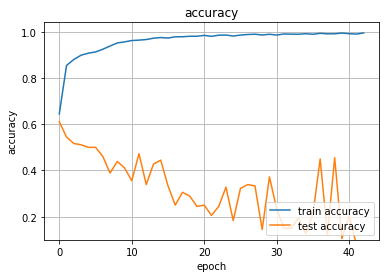

In [ ]:
accuracy_epoch_graph(train_accuracy_log,
                     test_accuracy_log)

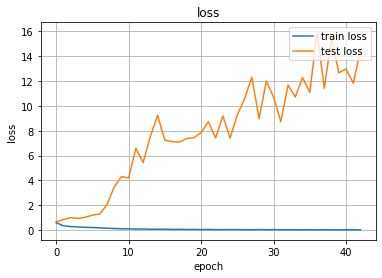

In [ ]:
train_loss_log = [i.cpu().detach().numpy()[()] for i in train_loss_log]
test_loss_log  = [i.cpu().numpy()[()]          for i in test_loss_log ]

loss_epoch_graph(train_loss_log, test_loss_log)

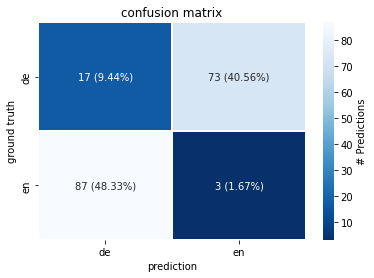

In [ ]:
predictions = predict(google, device, test_loader)
predictions = np.array(predictions)

ground_truth = test_df.iloc[:, 1:].astype('int').values

plot_cm(ground_truth, predictions)

## DenseNet

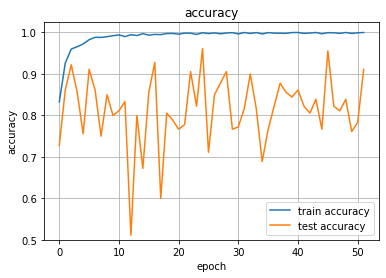

In [ ]:
accuracy_epoch_graph(train_accuracy_log,
                     test_accuracy_log)

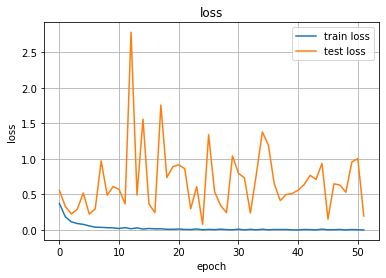

In [ ]:
train_loss_log = [i.cpu().detach().numpy()[()] for i in train_loss_log]
test_loss_log  = [i.cpu().numpy()[()]          for i in test_loss_log ]

loss_epoch_graph(train_loss_log, test_loss_log)

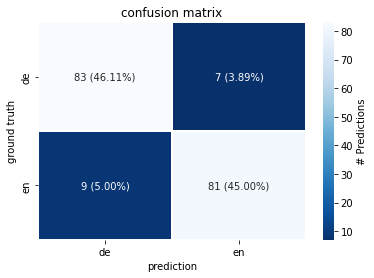

In [ ]:
predictions = predict(dense, device, test_loader)
predictions = np.array(predictions)

ground_truth = test_df.iloc[:, 1:].astype('int').values

plot_cm(ground_truth, predictions)